#MSPA PREDICT 400

##Discussion Topic: Week 1 Linear Functions

###Introduction

This document presents the results of the first weeks discussion topic for the Masters of Science in Predictive Analytics course: PREDICT 400. This assessment required the student to find an article that discusses some form of linear function, to summarize that article and reproduce analysis contained within the article.

###Article

For this assessment, I selected the article 'A Model of Australian Household Leverage' (the article). A copy of the article can be found <a href = "http://www.pimco.com.au/EN/Insights/Pages/A-Model-of-Australian-Household-Leverage.aspx">here</a>. The article focuses on answering a) which variables have explanatory power over household leverage (household debt to income ratio), b) if an increase in household wealth does in fact lead to an increase in consumption, and c) how households are likely to react to a potential decline in wealth. In order to address these questions, the article makes use of a vector autoregressive modelling framework with exogenous variables (VARX) relevant to both the Australian and U.S. markets. 

###Relevance

Prior to estimating the VARX for each country, the article tests the significance of predictors using simple linear regression. In order to address the requirements of this week's discussion topic, this assessment focuses on reproducing this preliminary linear regression analysis for the proposed Australian market predictors.

###Data

This assessment makes use of the same Australian predictors referenced by the article with a few exceptions. Predictors form a mix of economic and financial time series (quarterly) datasets, obtained from the Reserve Bank of Australia (RBA) and Australian Bureau of Statistics (ABS). These include:

- Household debt to income ratio, source <a href = "http://www.rba.gov.au">RBA</a>, Series ID BHFDDIT

- Wages and salaries, source <a href = "http://www.abs.gov.au">ABS</a>, Series ID A2302464V

- Net disposable income per capita, source <a href = "http://www.abs.gov.au">ABS</a>, Series ID A2302466X

- Unemployment rate, source <a href = "http://www.abs.gov.au">ABS</a>, Series ID A84423092X

- Household net worth, source <a href = "http://www.rba.gov.au">RBA</a>, Series ID BSPNSHUNW

- Household asset values, source <a href = "http://www.rba.gov.au">RBA</a>, Series ID BSPNSHNFD

- Mortgage Rate, source <a href = "http://www.rba.gov.au">RBA</a>, Series ID FILRHLBV

- House debt payment to disposable income, source <a href = "http://www.rba.gov.au">RBA</a>, Series ID BHFIPDH


Note:

- This assessment did not make use of the 'Westpac-Melbourne Institute Consumer Confidence' data series.

- All ABS data series used as part of this assessment are reported by the ABS as 'original' rather than 'seasonally' or 'trend' adjusted.

- The article refers to the Australian predictor dataset as having a sample period of June 1971 to June 2014, however, the RBA sourced data series mentioned above have limited this assessment to a sample period of September 1988 to September 2015.

###Assessment

####1. Loading the Data

Load datasets into a pandas dataframe.

In [1]:
import pandas as pd

houselev_raw_df = pd.read_csv("data/household_leverage.csv")
houselev_raw_df.head(10)

,Date,BHFDDIT,A2302464V,A2302466X,A84423092X,BSPNSHUNW,BSPNSHNFD,FILRHLBV,BHFIPDH
0,30/09/1988,63.000691,158070,8401,6.9,1068.653,634.7,8.05,5.219343
1,31/12/1988,66.603995,172717,9274,6.9,1117.892,683.0,8.05,5.350265
2,31/03/1989,68.137013,155626,8118,6.7,1147.106,713.8,8.05,5.524976
3,30/06/1989,68.894535,163547,8570,5.8,1179.259,736.4,8.05,5.786236
4,30/09/1989,68.253159,166761,8721,6.0,1216.935,752.8,8.05,6.184814
5,31/12/1989,68.635029,178154,9373,5.9,1228.812,764.1,8.05,5.940397
6,31/03/1990,69.380467,158881,8096,6.5,1244.017,780.5,8.05,5.832948
7,30/06/1990,71.040716,165254,8467,6.4,1257.470,797.0,8.05,5.780391
8,30/09/1990,69.830578,166709,8515,7.3,1256.250,795.9,8.05,5.693462
9,31/12/1990,70.423586,176782,9072,8.1,1259.080,801.1,8.30,5.463346


Check data types of each series.

In [2]:
print(houselev_raw_df.dtypes)

Date           object
BHFDDIT       float64
A2302464V       int64
A2302466X       int64
A84423092X    float64
BSPNSHUNW     float64
BSPNSHNFD     float64
FILRHLBV      float64
BHFIPDH       float64
dtype: object


Build a reference table for each data series.

In [3]:
data = ["BHFDDIT", 
        "A2302464V", 
        "A2302466X", 
        "A84423092X", 
        "BSPNSHUNW", 
        "BSPNSHNFD", 
        "FILRHLBV", 
        "BHFIPDH"]

desc = ["Household debt to income ratio", 
        "Wages and salaries", 
        "Net disposable income per capita", 
        "Unemployment rate", 
        "Household net worth", 
        "Household asset values", 
        "Mortage rate", 
        "House debt payment to disposable income"]

index = pd.DataFrame(desc, data)
index.columns = ["Description"]
index

,Description
BHFDDIT,Household debt to income ratio
A2302464V,Wages and salaries
A2302466X,Net disposable income per capita
A84423092X,Unemployment rate
BSPNSHUNW,Household net worth
BSPNSHNFD,Household asset values
FILRHLBV,Mortage rate
BHFIPDH,House debt payment to disposable income


####2. Pre-process the Data

Calculate percent changes between each quarter for all data series, and derive lagged data series up to five periods.

In [4]:
houselev_df = houselev_raw_df[data].pct_change()
houselev_df = houselev_df.join(houselev_raw_df["Date"])
houselev_df = houselev_df[["Date"] + data]
houselev_df = houselev_df.ix[1: ]

lags = [1, 2, 3, 4, 5]

for l in lags:
    houselev_lag_df = houselev_df.shift(l)
    houselev_lag_df = houselev_lag_df[data]
    houselev_lag_df.columns = houselev_lag_df.columns.map(lambda x: str(x) + "_" + str(l))
    houselev_df = houselev_df.join(houselev_lag_df)
    houselev_df = houselev_df.fillna(0)

The final post-processed dataset is shown below.

In [5]:
houselev_df.head(10)

,Date,BHFDDIT,A2302464V,A2302466X,A84423092X,BSPNSHUNW,BSPNSHNFD,FILRHLBV,BHFIPDH,BHFDDIT_1,...,FILRHLBV_4,BHFIPDH_4,BHFDDIT_5,A2302464V_5,A2302466X_5,A84423092X_5,BSPNSHUNW_5,BSPNSHNFD_5,FILRHLBV_5,BHFIPDH_5
1,31/12/1988,0.057195,0.092661,0.103916,0.000000,0.046076,0.076099,0.000000,0.025084,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000
2,31/03/1989,0.023017,-0.098954,-0.124650,-0.028986,0.026133,0.045095,0.000000,0.032655,0.057195,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000
3,30/06/1989,0.011118,0.050898,0.055679,-0.134328,0.028030,0.031662,0.000000,0.047287,0.023017,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000
4,30/09/1989,-0.009310,0.019652,0.017620,0.034483,0.031949,0.022271,0.000000,0.068884,0.011118,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000
5,31/12/1989,0.005595,0.068319,0.074762,-0.016667,0.009760,0.015011,0.000000,-0.039519,-0.009310,...,0,0.025084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000
6,31/03/1990,0.010861,-0.108182,-0.136242,0.101695,0.012374,0.021463,0.000000,-0.018088,0.005595,...,0,0.032655,0.057195,0.092661,0.103916,0.000000,0.046076,0.076099,0,0.025084
7,30/06/1990,0.023930,0.040112,0.045825,-0.015385,0.010814,0.021140,0.000000,-0.009010,0.010861,...,0,0.047287,0.023017,-0.098954,-0.124650,-0.028986,0.026133,0.045095,0,0.032655
8,30/09/1990,-0.017034,0.008805,0.005669,0.140625,-0.000970,-0.001380,0.000000,-0.015039,0.023930,...,0,0.068884,0.011118,0.050898,0.055679,-0.134328,0.028030,0.031662,0,0.047287
9,31/12/1990,0.008492,0.060423,0.065414,0.109589,0.002253,0.006533,0.031056,-0.040418,-0.017034,...,0,-0.039519,-0.009310,0.019652,0.017620,0.034483,0.031949,0.022271,0,0.068884
10,31/03/1991,0.008882,-0.115922,-0.145392,0.185185,0.026808,0.021720,0.000000,-0.056435,0.008492,...,0,-0.018088,0.005595,0.068319,0.074762,-0.016667,0.009760,0.015011,0,-0.039519


####3. Single Linear Regression

Estimate Ordinary Least Squares (OLS) based linear regression for 'household debt to income ratio' against 'wages and salaries'. Here, 'household debt to income ratio' is the dependent variable and 'wages and salaries' is used as the independent (explanatory) variable.

In [6]:
import statsmodels.api as sm

label = houselev_df["BHFDDIT"]

feat = houselev_df["A2302464V"]
#feat_c = sm.add_constant(feat)

ols_model = sm.OLS(label, feat)
ols_fitted = ols_model.fit()
ols_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BHFDDIT   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     9.531
Date:                Fri, 08 Jan 2016   Prob (F-statistic):            0.00257
Time:                        21:45:38   Log-Likelihood:                 298.10
No. Observations:                 108   AIC:                            -594.2
Df Residuals:                     107   BIC:                            -591.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
A2302464V      0.0816      0.026      3.087      0.003         0.029     0.134
==============================================================================
Omnibus:                        1.166   Durbin-Watson:                   0.839
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                0.684
Skew:                          -0.031   Prob(JB):                        0.710
Kurtosis:                       3.385   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see a positive coefficient, suggesting that an increase (decrease) in 'wages and salaries' tends to coincide with an increase (decrease) in the 'household debt to income ratio'. Do note however, the low R^2 value for this estimation.

A scatter plot of 'household debt to income ratio' against 'wages and salaries' is shown below, along with a plot of the above linear function. 

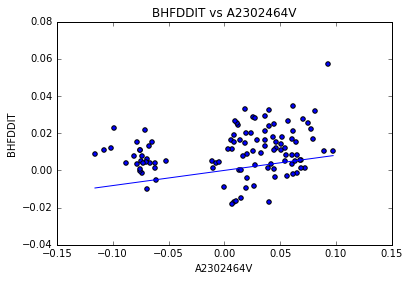

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

feat_pred = np.linspace(feat.min(), feat.max())
#feat_pred_c = sm.add_constant(feat_pred)

label_pred = ols_fitted.predict(feat_pred)

plt.scatter(feat, label)
plt.plot(feat_pred, label_pred)
plt.title("BHFDDIT vs A2302464V")
plt.ylabel("BHFDDIT")
plt.xlabel("A2302464V")
plt.show()

####4. Linear Regression Loop

Create a loop function which estimates an OLS based linear regression and prints the 'coefficient', 't-statistic', 'p-value' and 'R^2'. Each of the coefficients shown below are regressed against the same 'household debt to income ratio' dependent variable as per the above estimation.

In [8]:
import itertools
from scipy.stats import linregress

label = ["BHFDDIT"]

feat = ["A2302464V", 
        "A2302466X", 
        "A84423092X", 
        "BSPNSHUNW", 
        "BSPNSHNFD", 
        "FILRHLBV", 
        "BHFIPDH"]

desc = ["Wages and salaries", 
        "Net disposable income per capita", 
        "Unemployment rate", 
        "Household net worth", 
        "Household asset values", 
        "Mortage rate", 
        "House debt payment to disposable income"]

resultcols = ["Description", 
              "Coefficient", 
              "t-stat", 
              "p-value",
              "R^2"]

results_df = pd.DataFrame([])

for f, d in zip(feat, desc):
    #f_c = sm.add_constant(f)
    ols_model = sm.OLS(houselev_df[label], houselev_df[f])
    ols_fitted = ols_model.fit()
    
    #coefficient
    coeff = ols_fitted.params[0]
    #t-stat
    t_stat = ols_fitted.tvalues[0]
    #p-value
    p_value = ols_fitted.pvalues[0]
    #R^2
    r2 = ols_fitted.rsquared

    temp_df = pd.DataFrame([[d, 
                             coeff, 
                             t_stat, 
                             p_value, 
                             r2]], 
                           index = [f], columns = resultcols)
    
    results_df = results_df.append(temp_df)

results_df

,Description,Coefficient,t-stat,p-value,R^2
A2302464V,Wages and salaries,0.081561,3.087229,2.573100e-03,0.081789
A2302466X,Net disposable income per capita,0.058281,2.598742,1.067568e-02,0.059369
A84423092X,Unemployment rate,-0.055672,-2.870357,4.942458e-03,0.071494
BSPNSHUNW,Household net worth,0.336079,7.474830,2.235241e-11,0.343047
BSPNSHNFD,Household asset values,0.353942,8.862252,1.898103e-14,0.423303
FILRHLBV,Mortage rate,-0.060206,-1.109911,2.695257e-01,0.011382
BHFIPDH,House debt payment to disposable income,0.073378,2.103517,3.776457e-02,0.039711


The polarity of each coefficient seems reasonable. Estimations suggest an increase in 'wage and salaries', 'net disposable income per capita', 'household net worth', household asset values', or 'house debt payment to disposable income' tends to coincide with an increase in 'household debt to income ratio'. While an increase in 'unemployment rate' or 'mortgage rate' tends to coincide with a decrease in 'household debt to income ratio'.

Apply the loop function to the final Australian predictors presented within Table 4 of the article.

In [9]:
label = ["BHFDDIT"]

feat = ["BSPNSHNFD", 
        "BSPNSHNFD_1",
        "BSPNSHNFD_2",
        "BSPNSHUNW_1",
        "BSPNSHUNW_2",
        "FILRHLBV_3",
        "BSPNSHUNW",
        "FILRHLBV_4",
        "A84423092X",
        "FILRHLBV_2",
        "BHFIPDH_2",
        "BHFIPDH_3",
        "A2302466X"]
             
desc = ["Household asset values",
        "Household asset values (lag 1)",
        "Household asset values (lag 2)",
        "Household net worth (lag 1)",
        "Household net worth (lag 2)",
        "Mortage rate (lag 3)", 
        "Household net worth", 
        "Mortage rate (lag 4)", 
        "Unemployment rate", 
        "Mortage rate (lag 2)", 
        "House debt payment to disposable income (lag 2)",
        "House debt payment to disposable income (lag 3)",
        "Net disposable income per capita"]

resultcols = ["Description", 
              "Coefficient", 
              "t-stat", 
              "p-value",
              "R^2"]

results_df = pd.DataFrame([])

for f, d in zip(feat, desc):
    #f_c = sm.add_constant(f)
    ols_model = sm.OLS(houselev_df[label], houselev_df[f])
    ols_fitted = ols_model.fit()
    
    #coefficient
    coeff = ols_fitted.params[0]
    #t-stat
    t_stat = ols_fitted.tvalues[0]
    #p-value
    p_value = ols_fitted.pvalues[0]
    #R^2
    r2 = ols_fitted.rsquared

    temp_df = pd.DataFrame([[d, 
                             coeff, 
                             t_stat, 
                             p_value, 
                             r2]], 
                           index = [f], columns = resultcols)
    
    results_df = results_df.append(temp_df)

results_df

,Description,Coefficient,t-stat,p-value,R^2
BSPNSHNFD,Household asset values,0.353942,8.862252,1.898103e-14,0.423303
BSPNSHNFD_1,Household asset values (lag 1),0.295371,6.658483,1.227156e-09,0.292961
BSPNSHNFD_2,Household asset values (lag 2),0.265380,5.707860,1.032718e-07,0.233413
BSPNSHUNW_1,Household net worth (lag 1),0.301756,6.391537,4.385056e-09,0.276302
BSPNSHUNW_2,Household net worth (lag 2),0.269179,5.473577,2.932802e-07,0.218750
FILRHLBV_3,Mortage rate (lag 3),-0.004043,-0.073523,9.415271e-01,0.000051
BSPNSHUNW,Household net worth,0.336079,7.474830,2.235241e-11,0.343047
FILRHLBV_4,Mortage rate (lag 4),-0.029918,-0.544863,5.869817e-01,0.002767
A84423092X,Unemployment rate,-0.055672,-2.870357,4.942458e-03,0.071494
FILRHLBV_2,Mortage rate (lag 2),-0.060373,-1.104231,2.719702e-01,0.011267


Although the polarity of each coefficient reported above matches those shown within the article, the actual coefficient values and their associated statistics do not. However, the above results are consistent with the article in reporting that 'households asset values' has the greatest absolute coefficient and greatest R^2.

####5. Scatter Plot Loop

Finally, a loop function is created which produces a scatter and linear plot for the variable combinations shown within Figure 1 of the article.

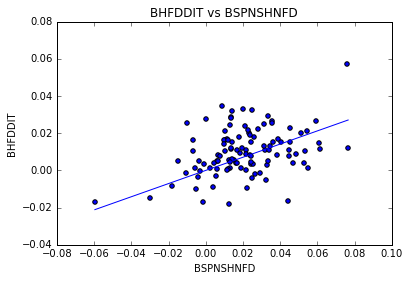

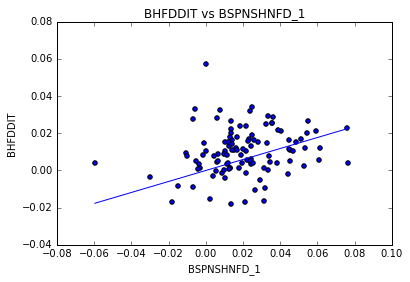

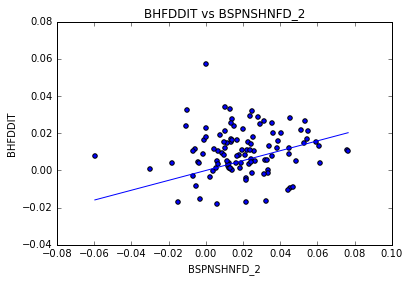

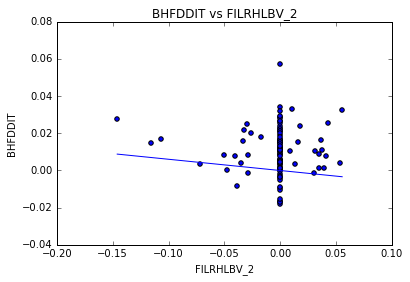

In [10]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

label = ["BHFDDIT"]

feat = ["BSPNSHNFD",
        "BSPNSHNFD_1",
        "BSPNSHNFD_2",
        "FILRHLBV_2"]

for f in feat:
    label = houselev_df["BHFDDIT"]
    
    feat = houselev_df[f]
    #feat_c = sm.add_constant(f)
    
    ols_model = sm.OLS(label, feat)
    ols_fitted = ols_model.fit()

    feat_pred = np.linspace(feat.min(), feat.max())
    #feat_pred_c = sm.add_constant(feat_pred)

    label_pred = ols_fitted.predict(feat_pred)

    plt.scatter(feat, label)
    plt.plot(feat_pred, label_pred)
    plt.title("BHFDDIT" + " vs " + f)
    plt.ylabel("BHFDDIT")
    plt.xlabel(f)
    plt.show()

Each plot shown above bears some resemblance to the plots shown in Figure 1 of the article.

###Conclusion

This assessment was able to reproduce similar results to the preliminary Australian predictor regression analysis shown within the article. The most likely reason for the inability to exactly reproduce the article's results relates back to inconsistencies between datasets. As noted, I was unable to reconcile back to the same sample period as that noted by the article. There may also have been mismatches between selected ABS based data series, i.e. I made a conscious effort to select 'original' datasets rather than those that have been 'seasonally' or 'trend' adjusted, however a preference was not noted by the article.